In [1]:
import numpy as np
from numba import njit, vectorize, prange
import matplotlib.pyplot as plt
%matplotlib inline
from math import gamma

In [2]:
# Parameters in the two beta distributions.
F_a, F_b = 1, 1
G_a, G_b = 3, 1.2

@vectorize
def p(w, a, b):
    r = gamma(a + b) / (gamma(a) * gamma(b))
    return r * w ** (a-1) * (1 - w) ** (b-1)

# The two density functions.
f = njit(lambda w: p(w, F_a, F_b))
g = njit(lambda w: p(w, G_a, G_b))

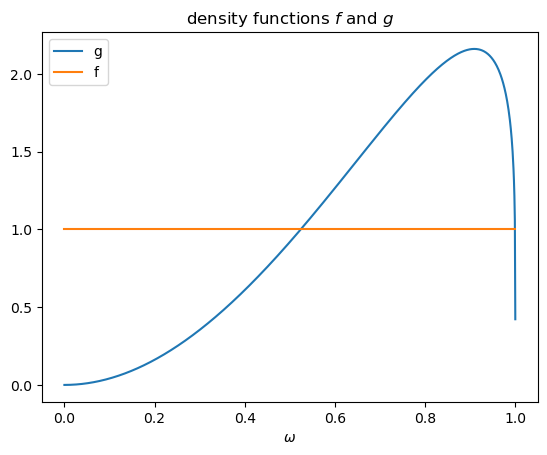

In [3]:
w_range = np.linspace(1e-5, 1-1e-5, 1000)

plt.plot(w_range, g(w_range), label='g')
plt.plot(w_range, f(w_range), label='f')
plt.xlabel('$\omega$')
plt.legend()
plt.title('density functions $f$ and $g$')
plt.show()

In [4]:
l = njit(lambda w: f(w) / g(w))

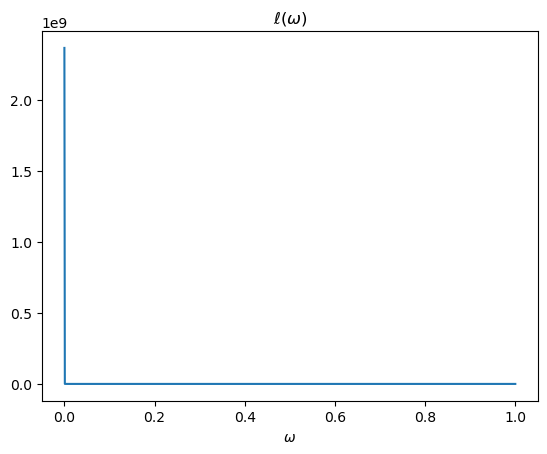

In [5]:
plt.plot(w_range, l(w_range))
plt.title('$\ell(\omega)$')
plt.xlabel('$\omega$')
plt.show()

In [6]:
g_a, g_b = G_a, G_b
h_a, h_b = 0.5, 0.5

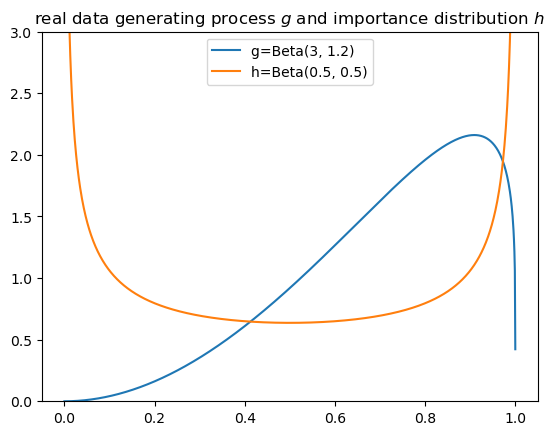

In [7]:
w_range = np.linspace(1e-5, 1-1e-5, 1000)

plt.plot(w_range, g(w_range), label=f'g=Beta({g_a}, {g_b})')
plt.plot(w_range, p(w_range, 0.5, 0.5), label=f'h=Beta({h_a}, {h_b})')
plt.title('real data generating process $g$ and importance distribution $h$')
plt.legend()
plt.ylim([0., 3.])
plt.show()

In [8]:
@njit(parallel=True)
def estimate(p_a, p_b, q_a, q_b, T=1, N=10000):

    μ_L = 0
    for i in prange(N):

        L = 1
        weight = 1
        for t in range(T):
            w = np.random.beta(q_a, q_b)
            l = f(w) / g(w)

            L *= l
            weight *= p(w, p_a, p_b) / p(w, q_a, q_b)

        μ_L += L * weight

    μ_L /= N

    return μ_L

In [9]:
estimate(g_a, g_b, g_a, g_b, T=1, N=10000)

1.0152797003985397

In [10]:
estimate(g_a, g_b, h_a, h_b, T=1, N=10000)

1.0037240579118656

In [11]:
estimate(g_a, g_b, g_a, g_b, T=10, N=10000)

1.0974192402854674

In [12]:
estimate(g_a, g_b, h_a, h_b, T=10, N=10000)

1.0144183913454343

In [13]:
@njit(parallel=True)
def simulate(p_a, p_b, q_a, q_b, N_simu, T=1):

    μ_L_p = np.empty(N_simu)
    μ_L_q = np.empty(N_simu)

    for i in prange(N_simu):
        μ_L_p[i] = estimate(p_a, p_b, p_a, p_b, T=T)
        μ_L_q[i] = estimate(p_a, p_b, q_a, q_b, T=T)

    return μ_L_p, μ_L_q

In [14]:
N_simu = 1000
μ_L_p, μ_L_q = simulate(g_a, g_b, h_a, h_b, N_simu)

In [15]:
# standard Monte Carlo (mean and std)
np.nanmean(μ_L_p), np.nanvar(μ_L_p)

(1.0160254810461966, 0.41566917057361963)

In [16]:
# importance sampling (mean and std)
np.nanmean(μ_L_q), np.nanvar(μ_L_q)

(1.0000718434851181, 2.2719734977390418e-05)

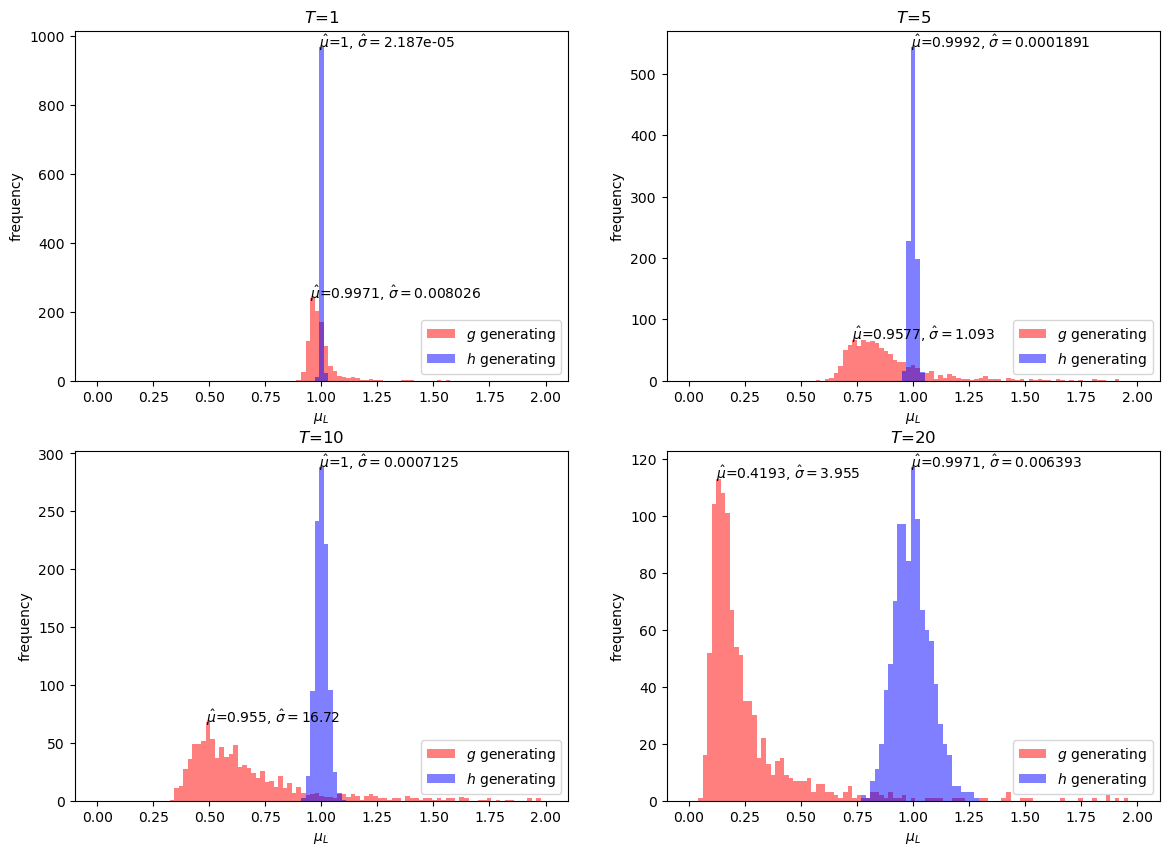

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

μ_range = np.linspace(0, 2, 100)

for i, t in enumerate([1, 5, 10, 20]):
    row = i // 2
    col = i % 2

    μ_L_p, μ_L_q = simulate(g_a, g_b, h_a, h_b, N_simu, T=t)
    μ_hat_p, μ_hat_q = np.nanmean(μ_L_p), np.nanmean(μ_L_q)
    σ_hat_p, σ_hat_q = np.nanvar(μ_L_p), np.nanvar(μ_L_q)

    axs[row, col].set_xlabel('$μ_L$')
    axs[row, col].set_ylabel('frequency')
    axs[row, col].set_title(f'$T$={t}')
    n_p, bins_p, _ = axs[row, col].hist(μ_L_p, bins=μ_range, color='r', alpha=0.5, label='$g$ generating')
    n_q, bins_q, _ = axs[row, col].hist(μ_L_q, bins=μ_range, color='b', alpha=0.5, label='$h$ generating')
    axs[row, col].legend(loc=4)

    for n, bins, μ_hat, σ_hat in [[n_p, bins_p, μ_hat_p, σ_hat_p],
                                  [n_q, bins_q, μ_hat_q, σ_hat_q]]:
        idx = np.argmax(n)
        axs[row, col].text(bins[idx], n[idx], '$\hat{μ}$='+f'{μ_hat:.4g}'+', $\hat{σ}=$'+f'{σ_hat:.4g}')

plt.show()

In [18]:
μ_L_p, μ_L_q = simulate(g_a, g_b, F_a, F_b, N_simu)

In [19]:
# importance sampling (mean and std)
np.nanmean(μ_L_q), np.nanvar(μ_L_q)

(1.0, 0.0)

In [20]:
a_list = [0.5, 1., 2.]
b_list = [0.5, 1.2, 5.]

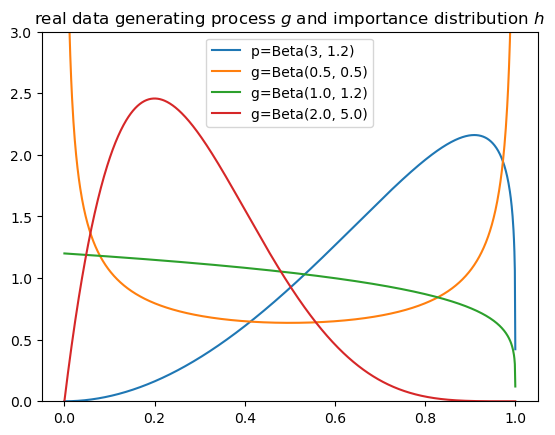

In [21]:
w_range = np.linspace(1e-5, 1-1e-5, 1000)

plt.plot(w_range, g(w_range), label=f'p=Beta({g_a}, {g_b})')
plt.plot(w_range, p(w_range, a_list[0], b_list[0]), label=f'g=Beta({a_list[0]}, {b_list[0]})')
plt.plot(w_range, p(w_range, a_list[1], b_list[1]), label=f'g=Beta({a_list[1]}, {b_list[1]})')
plt.plot(w_range, p(w_range, a_list[2], b_list[2]), label=f'g=Beta({a_list[2]}, {b_list[2]})')
plt.title('real data generating process $g$ and importance distribution $h$')
plt.legend()
plt.ylim([0., 3.])
plt.show()

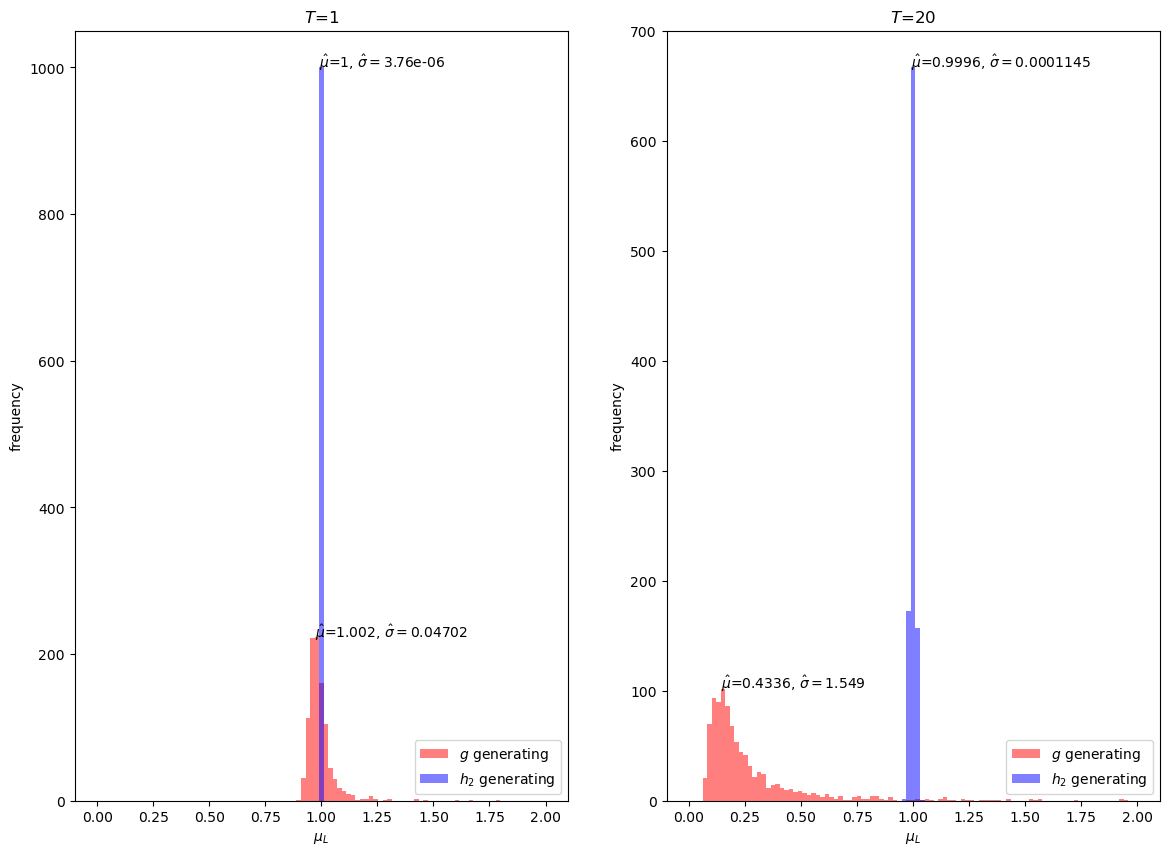

In [22]:
h_a = a_list[1]
h_b = b_list[1]

fig, axs = plt.subplots(1,2, figsize=(14, 10))

μ_range = np.linspace(0, 2, 100)

for i, t in enumerate([1, 20]):


    μ_L_p, μ_L_q = simulate(g_a, g_b, h_a, h_b, N_simu, T=t)
    μ_hat_p, μ_hat_q = np.nanmean(μ_L_p), np.nanmean(μ_L_q)
    σ_hat_p, σ_hat_q = np.nanvar(μ_L_p), np.nanvar(μ_L_q)

    axs[i].set_xlabel('$μ_L$')
    axs[i].set_ylabel('frequency')
    axs[i].set_title(f'$T$={t}')
    n_p, bins_p, _ = axs[i].hist(μ_L_p, bins=μ_range, color='r', alpha=0.5, label='$g$ generating')
    n_q, bins_q, _ = axs[i].hist(μ_L_q, bins=μ_range, color='b', alpha=0.5, label='$h_2$ generating')
    axs[i].legend(loc=4)

    for n, bins, μ_hat, σ_hat in [[n_p, bins_p, μ_hat_p, σ_hat_p],
                                  [n_q, bins_q, μ_hat_q, σ_hat_q]]:
        idx = np.argmax(n)
        axs[i].text(bins[idx], n[idx], '$\hat{μ}$='+f'{μ_hat:.4g}'+', $\hat{σ}=$'+f'{σ_hat:.4g}')

plt.show()

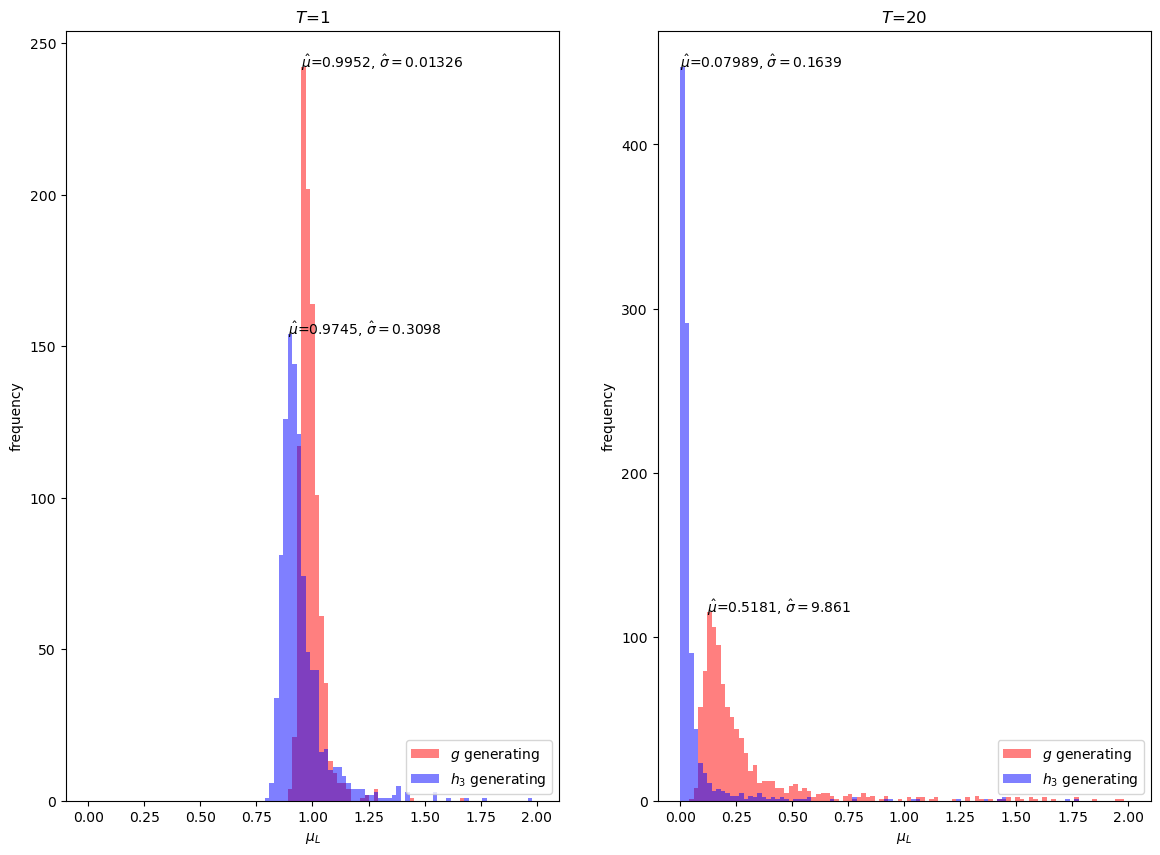

In [23]:
h_a = a_list[2]
h_b = b_list[2]

fig, axs = plt.subplots(1,2, figsize=(14, 10))

μ_range = np.linspace(0, 2, 100)

for i, t in enumerate([1, 20]):


    μ_L_p, μ_L_q = simulate(g_a, g_b, h_a, h_b, N_simu, T=t)
    μ_hat_p, μ_hat_q = np.nanmean(μ_L_p), np.nanmean(μ_L_q)
    σ_hat_p, σ_hat_q = np.nanvar(μ_L_p), np.nanvar(μ_L_q)

    axs[i].set_xlabel('$μ_L$')
    axs[i].set_ylabel('frequency')
    axs[i].set_title(f'$T$={t}')
    n_p, bins_p, _ = axs[i].hist(μ_L_p, bins=μ_range, color='r', alpha=0.5, label='$g$ generating')
    n_q, bins_q, _ = axs[i].hist(μ_L_q, bins=μ_range, color='b', alpha=0.5, label='$h_3$ generating')
    axs[i].legend(loc=4)

    for n, bins, μ_hat, σ_hat in [[n_p, bins_p, μ_hat_p, σ_hat_p],
                                  [n_q, bins_q, μ_hat_q, σ_hat_q]]:
        idx = np.argmax(n)
        axs[i].text(bins[idx], n[idx], '$\hat{μ}$='+f'{μ_hat:.4g}'+', $\hat{σ}=$'+f'{σ_hat:.4g}')

plt.show()